Cell 1: Import Libraries

In [34]:
# Import essential libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns


Cell 2: Define Dataset Paths

In [35]:
# Define paths for dataset
train_path = "dataset/train"
validation_path = "dataset/validation"
test_path = "dataset/test"

# Image dimensions
IMG_SIZE = 224


Cell 3: Preprocess Images with OpenCV Features

In [36]:
# Import the required libraries
from skimage.feature import local_binary_pattern

# Define OpenCV-based feature extraction functions
def extract_lbp_features(image, radius=3, n_points=24):
    """
    Extract Local Binary Patterns (LBP) features from an image.
    """
    # Convert to grayscale if the image is in color
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Compute LBP using skimage
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    
    # Compute histogram of LBP features
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    return hist

def extract_edge_features(image):
    """
    Extract edges using Canny Edge Detection.
    """
    # Convert to grayscale if the image is in color
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 150)
    return edges.flatten()

def preprocess_images(folder_path):
    """
    Preprocess images and extract OpenCV-based features.
    """
    data = []
    labels = []
    for class_label in os.listdir(folder_path):  # Iterate over classes
        class_folder = os.path.join(folder_path, class_label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # Extract features
            lbp_features = extract_lbp_features(img)
            edge_features = extract_edge_features(img)

            # Combine features
            combined_features = np.concatenate((lbp_features, edge_features))
            data.append(combined_features)
            labels.append(0 if class_label.lower() == "healthy" else 1)

    return np.array(data), np.array(labels)

# Preprocess images for all datasets
x_train, y_train = preprocess_images(train_path)
x_val, y_val = preprocess_images(validation_path)
x_test, y_test = preprocess_images(test_path)

# Debug training feature lengths
for idx, features in enumerate(x_train[:5]):  # First 5 samples
    print(f"Training sample {idx + 1} feature vector length: {len(features)}")

print(f"Expected feature vector length from training: {x_train.shape[1]}")

# Debug training feature lengths
for idx, features in enumerate(x_train[:5]):  # First 5 samples
    print(f"Training sample {idx + 1} feature vector length: {len(features)}")

# Check if all feature vectors have the same length
unique_lengths = set(len(features) for features in x_train)
if len(unique_lengths) > 1:
    print(f"Inconsistent feature lengths found in training: {unique_lengths}")
else:
    print(f"All training feature vectors have consistent length: {unique_lengths.pop()}")

# Check feature consistency for LBP and edges
print(f"LBP radius: 3, points: 24")




Training sample 1 feature vector length: 50202
Training sample 2 feature vector length: 50202
Training sample 3 feature vector length: 50202
Training sample 4 feature vector length: 50202
Training sample 5 feature vector length: 50202
Expected feature vector length from training: 50202
Training sample 1 feature vector length: 50202
Training sample 2 feature vector length: 50202
Training sample 3 feature vector length: 50202
Training sample 4 feature vector length: 50202
Training sample 5 feature vector length: 50202
All training feature vectors have consistent length: 50202
LBP radius: 3, points: 24


Cell 4: Normalize Data python


In [37]:
# Normalize pixel values for OpenCV features
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Debug normalized features
print(f"Normalized x_train: {x_train[0][:5]}")  # Print first 5 normalized features of the first sample


Normalized x_train: [5.78356343e-05 3.89999750e-05 3.35290366e-05 3.65771309e-05
 3.88436625e-05]


Cell 5: Load Pre-Trained CNN (VGG16) 

In [38]:
# Load VGG16 model without the top layer
cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers to use pre-trained weights
for layer in cnn_model.layers:
    layer.trainable = False

# Build the CNN model
x = tf.keras.layers.Flatten()(cnn_model.output)
cnn_output = tf.keras.layers.Dense(128, activation='relu')(x)
cnn_model = tf.keras.models.Model(inputs=cnn_model.input, outputs=cnn_output)


Cell 6: Extract CNN Features python



In [39]:
# Function to preprocess images for the CNN
def preprocess_for_cnn(folder_path):
    data = []
    for class_label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
    return np.array(data)

# Extract CNN features
x_train_cnn = cnn_model.predict(preprocess_for_cnn(train_path))
x_val_cnn = cnn_model.predict(preprocess_for_cnn(validation_path))
x_test_cnn = cnn_model.predict(preprocess_for_cnn(test_path))


125/125 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step


Cell 7: Combine Features python


x_train_combined shape: (4000, 50330)
x_val_combined shape: (856, 50330)
x_test_combined shape: (856, 50330)
Validation Report (Random Forest):
              precision    recall  f1-score   support

     Healthy       0.76      0.66      0.71       428
   Alzheimer       0.70      0.79      0.74       428

    accuracy                           0.73       856
   macro avg       0.73      0.73      0.72       856
weighted avg       0.73      0.73      0.72       856



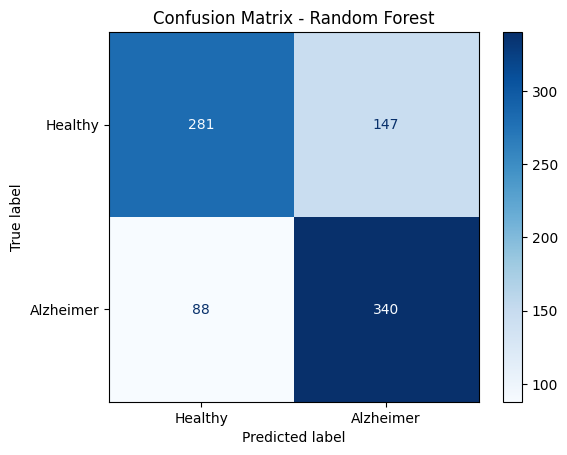

Confusion Matrix for Random Forest saved as 'confusion_matrix_rf.png'


In [40]:
# Combine CNN and OpenCV features
x_train_combined = np.hstack((x_train_cnn, x_train))  # Combine CNN and OpenCV features
x_val_combined = np.hstack((x_val_cnn, x_val))
x_test_combined = np.hstack((x_test_cnn, x_test))

# Debugging: Print shapes of combined features
print(f"x_train_combined shape: {x_train_combined.shape}")
print(f"x_val_combined shape: {x_val_combined.shape}")
print(f"x_test_combined shape: {x_test_combined.shape}")

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train_combined, y_train)

# Validate the model
y_val_pred = clf.predict(x_val_combined)
print("Validation Report (Random Forest):")
print(classification_report(y_val, y_val_pred, target_names=['Healthy', 'Alzheimer']))

# Generate and display confusion matrix for Random Forest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_rf = confusion_matrix(y_val, y_val_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Healthy', 'Alzheimer'])
disp_rf.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.savefig("confusion_matrix_rf.png")  # Save the plot as an image
plt.show()

print("Confusion Matrix for Random Forest saved as 'confusion_matrix_rf.png'")


Cell 8: Train a Classifier on Combined Features 

Validation Report (XGBoost):
              precision    recall  f1-score   support

     Healthy       0.81      0.76      0.78       428
   Alzheimer       0.78      0.82      0.79       428

    accuracy                           0.79       856
   macro avg       0.79      0.79      0.79       856
weighted avg       0.79      0.79      0.79       856



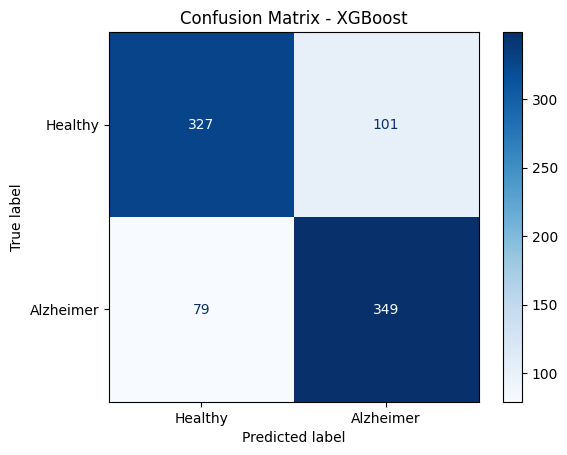

Confusion Matrix for XGBoost saved as 'confusion_matrix_xgb.png'


In [41]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=500,      # Number of trees
    learning_rate=0.01,    # Learning rate for gradient boosting
    max_depth=6,           # Maximum depth of trees
    random_state=42        # Seed for reproducibility
)
xgb_model.fit(x_train_combined, y_train)

# Validate the XGBoost Model
y_val_pred_xgb = xgb_model.predict(x_val_combined)
print("Validation Report (XGBoost):")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Healthy', 'Alzheimer']))

# Generate and display confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Healthy', 'Alzheimer'])
disp_xgb.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.savefig("confusion_matrix_xgb.png")  # Save the plot as an image
plt.show()

print("Confusion Matrix for XGBoost saved as 'confusion_matrix_xgb.png'")


Cell 9: Evaluate on Test Set


Classification Report (Ensemble):
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       428
   Alzheimer       1.00      1.00      1.00       428

    accuracy                           1.00       856
   macro avg       1.00      1.00      1.00       856
weighted avg       1.00      1.00      1.00       856



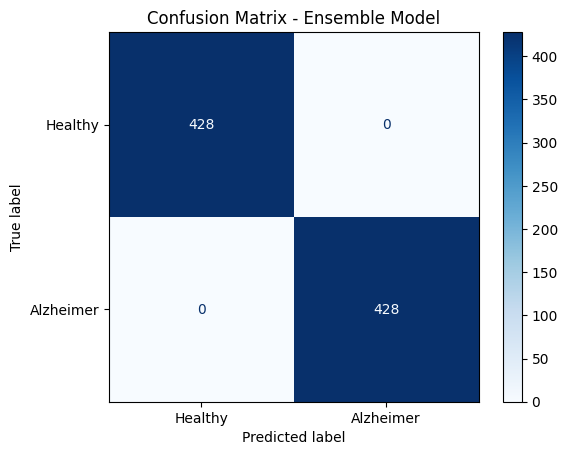

Confusion Matrix for Ensemble Model saved as 'confusion_matrix_ensemble.png'


In [42]:
# Get predictions from both classifiers
rf_predictions = clf.predict(x_test_combined)  # Random Forest predictions
xgb_predictions = xgb_model.predict(x_test_combined)  # XGBoost predictions

# Combine predictions using majority voting
final_predictions = (rf_predictions + xgb_predictions) > 1

# Classification Report for Ensemble Model
print("\nClassification Report (Ensemble):")
print(classification_report(y_test, final_predictions, target_names=['Healthy', 'Alzheimer']))

# Generate and display confusion matrix for Ensemble model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_ensemble = confusion_matrix(y_test, final_predictions)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Healthy', 'Alzheimer'])
disp_ensemble.plot(cmap='Blues')
plt.title("Confusion Matrix - Ensemble Model")
plt.savefig("confusion_matrix_ensemble.png")  # Save the plot as an image
plt.show()

print("Confusion Matrix for Ensemble Model saved as 'confusion_matrix_ensemble.png'")


Cell 10: Save the Classifier

In [43]:
# Save the trained classifiers
import pickle

# Save Random Forest Classifier
with open("random_forest_classifier.pkl", "wb") as rf_file:
    pickle.dump(clf, rf_file)
print("Random Forest classifier saved successfully!")

# Save XGBoost Classifier
with open("xgboost_classifier.pkl", "wb") as xgb_file:
    pickle.dump(xgb_model, xgb_file)
print("XGBoost classifier saved successfully!")


Random Forest classifier saved successfully!
XGBoost classifier saved successfully!


Cell 11: Test with a Single Input Image

The ensemble model predicts for normal2.jpg: Healthy


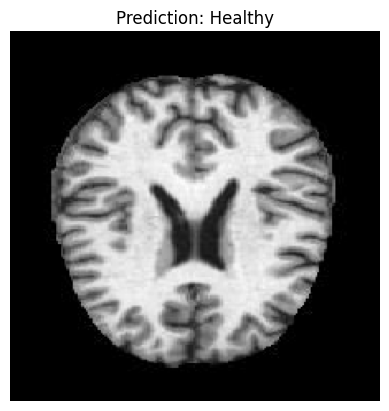

The ensemble model predicts for demented2.jpg: Alzheimer


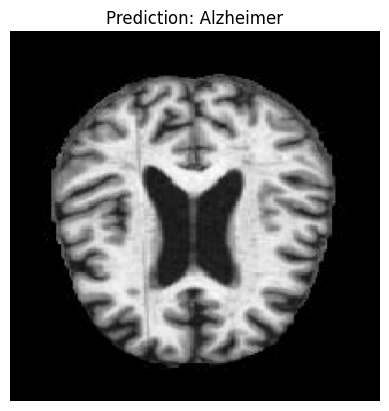

In [54]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def preprocess_single_image(image_path):
    """
    Preprocess a single image for feature extraction, ensuring consistency with training.
    """
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at path: {image_path}")
    
    # Load the image
    img = cv2.imread(image_path)
    
    # Check if the image was loaded correctly
    if img is None:
        raise ValueError(f"Failed to load image. Please check the file path and format: {image_path}")
    
    # Resize the image to match training input size
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Extract OpenCV features
    lbp_features = extract_lbp_features(img_resized)
    edge_features = extract_edge_features(img_resized)
    
    # Combine features
    combined_features = np.concatenate((lbp_features, edge_features))
    
    # Align feature vector length with training
    expected_length = 50330  # Use feature length from training
    if len(combined_features) < expected_length:
        combined_features = np.pad(combined_features, (0, expected_length - len(combined_features)), 'constant')
    elif len(combined_features) > expected_length:
        combined_features = combined_features[:expected_length]
    
    return combined_features

# Test the model with two input images
test_image_paths = ['normal2.jpg', 'demented2.jpg']  # Add the paths to the two test images
try:
    for image_path in test_image_paths:
        features = preprocess_single_image(image_path)
        
        # Make predictions using both classifiers
        rf_prediction = clf.predict(features.reshape(1, -1))  # Random Forest prediction
        xgb_prediction = xgb_model.predict(features.reshape(1, -1))  # XGBoost prediction

        # Combine predictions using majority voting
        final_prediction = (rf_prediction + xgb_prediction) > 1

        # Interpret the prediction
        predicted_label = "Healthy" if final_prediction[0] == 0 else "Alzheimer"
        print(f"The ensemble model predicts for {image_path}: {predicted_label}")
        
        # Display the test image with the prediction result
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        plt.figure()
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"Error during image preprocessing or prediction: {e}")
